# Bootstrapped LOWESS for Confidence Intervals

This notebook outlines how to use the `moepy` library to generate confidence intervals around the LOWESS estimates, using the famous LIGO gravitationl wave data as an example. 

N.b. I have no expertise of signal processing in this particular context, this is merely an example of how LOWESS confidence intervals can be used to limit the domain of your prediction to where you have greatest certainty in it.

<br>

### Imports

In [21]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from moepy import lowess, eda

<br>

### Loading Data

We'll start by loading the LIGO data in

In [2]:
df_LIGO = pd.read_csv('../data/lowess_examples/LIGO.csv')

df_LIGO.head()

,frequency,L1,H1,H1_smoothed
0,0.00,2.383528e-18,2.215686e-20,3.240000e-18
1,0.25,1.685617e-18,2.013959e-20,2.644898e-19
2,0.50,1.242968e-21,5.518498e-21,9.000000e-20
3,0.75,6.677796e-22,2.546120e-21,4.484429e-20
4,1.00,6.800320e-22,3.339454e-21,2.677686e-20


<br>

### Baseline Fit

We'll quickly plot the observed data alongside the smoothed estimate provided in the raw data

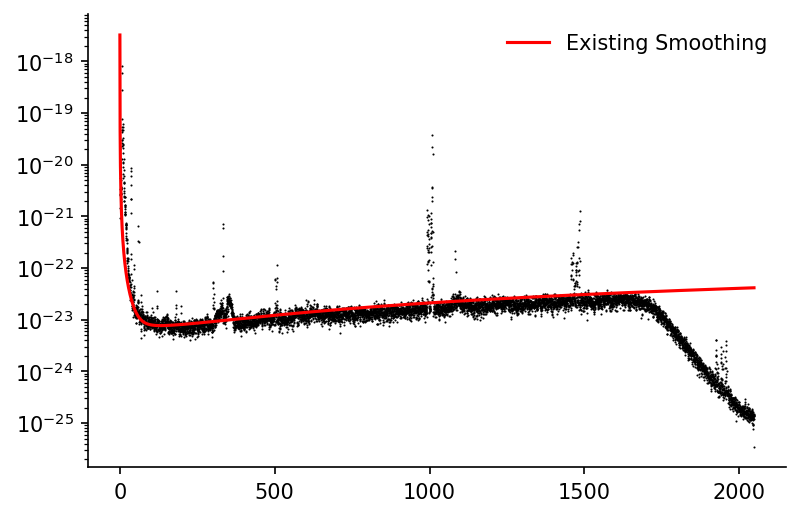

In [10]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_LIGO['frequency'], df_LIGO['H1'], color='k', linewidth=0, s=1)
ax.plot(df_LIGO['frequency'], df_LIGO['H1_smoothed'], color='r', alpha=1, label='Existing Smoothing')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(frameon=False)
eda.hide_spines(ax)

<br>

### LOWESS Fit

In [11]:
x = df_LIGO['frequency'].values
y = np.log(df_LIGO['H1']).values

df_bootstrap = lowess.bootstrap_model(x, y, num_runs=2500, frac=0.2, num_fits=30)

df_bootstrap.head()

 [████████████████████████████████████████████████████████████] 2500/2500 [05:54<00:00, 0.14s/it]

c:\users\ayrto\desktop\phd\analysis\merit-order-effect\moepy\lowess.py:145: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas = np.linalg.lstsq(A, b)[0]


bootstrap_run,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
x,,,,,,,,,,,,,,,,,,,,,
0.00,-52.620421,-52.698863,-52.653935,-52.424510,-52.775429,-52.534803,-52.549456,-52.622501,-52.465228,-52.443828,...,-52.518676,-52.473980,-52.556004,-52.393600,-52.421684,-52.499250,-52.620757,-52.516568,-52.554362,-52.387421
0.25,-52.621127,-52.699445,-52.654609,-52.425473,-52.775842,-52.535606,-52.550253,-52.623202,-52.466117,-52.444801,...,-52.519519,-52.474887,-52.556854,-52.394649,-52.422691,-52.500161,-52.621387,-52.517321,-52.555185,-52.388424
0.50,-52.621834,-52.700027,-52.655283,-52.426435,-52.776254,-52.536409,-52.551049,-52.623903,-52.467006,-52.445773,...,-52.520361,-52.475793,-52.557703,-52.395697,-52.423698,-52.501071,-52.622016,-52.518074,-52.556008,-52.389426
0.75,-52.622540,-52.700608,-52.655957,-52.427397,-52.776667,-52.537211,-52.551844,-52.624603,-52.467894,-52.446744,...,-52.521203,-52.476699,-52.558552,-52.396745,-52.424704,-52.501981,-52.622645,-52.518827,-52.556831,-52.390427
1.00,-52.623245,-52.701190,-52.656630,-52.428358,-52.777078,-52.538013,-52.552639,-52.625302,-52.468782,-52.447715,...,-52.522044,-52.477604,-52.559401,-52.397792,-52.425710,-52.502889,-52.623273,-52.519579,-52.557653,-52.391428


<br>

Using `df_bootstrap` we can calculate the confidence interval of our predictions, the Pandas DataFrame `quantile` method makes this particularly simple.

In [12]:
#exports
def get_confidence_interval(df_bootstrap, conf_pct=0.95):
    """Estimates the confidence interval of a prediction based on the bootstrapped estimates"""
    conf_margin = (1 - conf_pct)/2
    df_conf_intvl = pd.DataFrame(columns=['min', 'max'], index=df_bootstrap.index)
    
    df_conf_intvl['min'] = df_bootstrap.quantile(conf_margin, axis=1)
    df_conf_intvl['max'] = df_bootstrap.quantile(1-conf_margin, axis=1)
    
    return df_conf_intvl

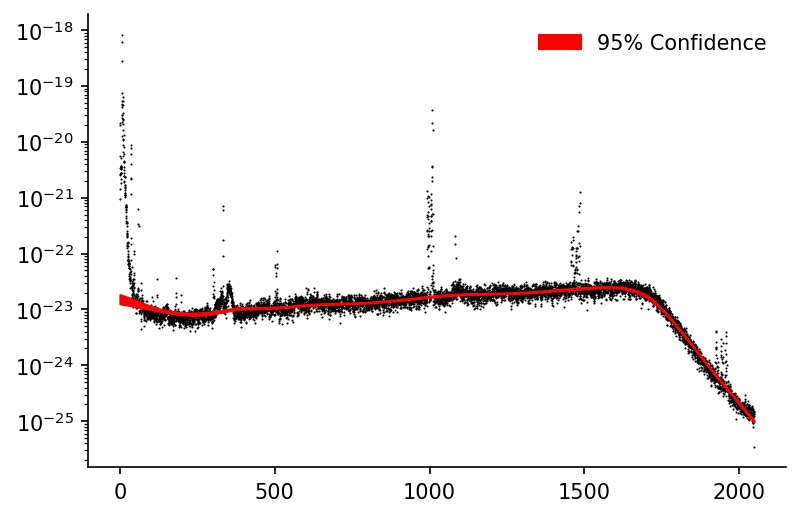

In [13]:
df_conf_intvl = get_confidence_interval(df_bootstrap, conf_pct=0.95)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_LIGO['frequency'], df_LIGO['H1'], color='k', linewidth=0, s=1, zorder=1)
ax.fill_between(df_conf_intvl.index, np.exp(df_conf_intvl['min']), np.exp(df_conf_intvl['max']), color='r', alpha=1, label='95% Confidence')

ax.set_yscale('log')
ax.legend(frameon=False)
eda.hide_spines(ax)

<br>

We can see that we capture the middle and higher frequencies fairly well but due to the smaller number of data-points in the low frequency region the LOWESS fit is unable to model it as well. The `frac` could be decreased to improve this but then comes at the cost of processing more inaccurate estimates in the other regions. One way to address this could be to introduce an option where `frac` can be varied for each local regression model.

For now we'll just limit our prediction to the domain where the confidence interval is 'reasonable', we'll start by calculating the 95% confidence interval.

In [48]:
s_95pct_conf_intvl = (df_bootstrap
                      .quantile([0.025, 0.975], axis=1)
                      .diff()
                      .dropna(how='all')
                      .T
                      .rename(columns={0.975: '95pct_pred_intvl'})
                      ['95pct_pred_intvl']
                     )

s_95pct_conf_intvl

x
0.00       0.378534
0.25       0.377999
0.50       0.377465
0.75       0.376930
1.00       0.376396
             ...   
2047.00    0.076900
2047.25    0.076980
2047.50    0.077059
2047.75    0.077139
2048.00    0.077222
Name: 95pct_pred_intvl, Length: 8193, dtype: float64

<br>

We'll now define the 'reasonable' confidence interval threshold, in this case using the value that icludes 95% of the values.

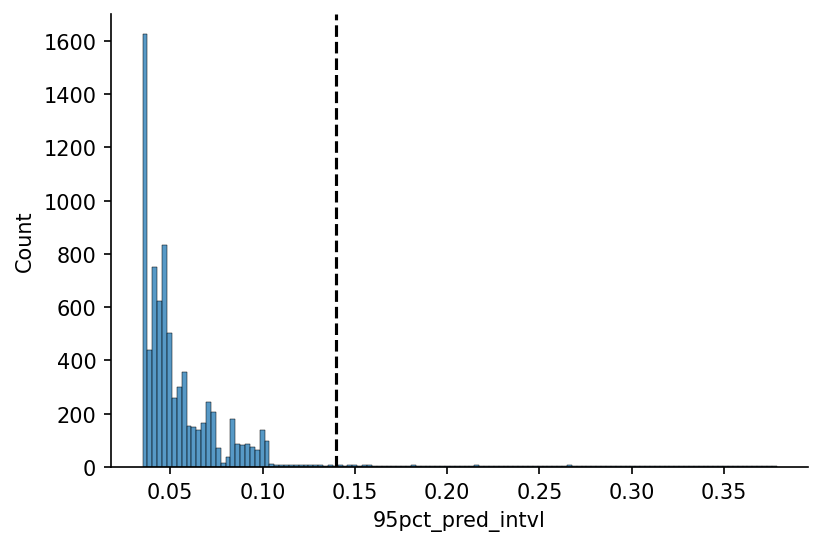

In [55]:
x_max_pct = 0.95

# Plotting
fig, ax = plt.subplots(dpi=150)

hist = sns.histplot(s_95pct_conf_intvl, ax=ax)

y_max = np.ceil(max([h.get_height() for h in hist.patches])/1e2)*1e2
x_max = s_95pct_conf_intvl.quantile(x_max_pct)
ax.plot([x_max, x_max], [0, y_max], linestyle='--', color='k', label='95% Coverage')

ax.set_ylim(0, y_max)
eda.hide_spines(ax)

<br>

We'll then only plot our confidence interval when it's in this 'reasonable' range

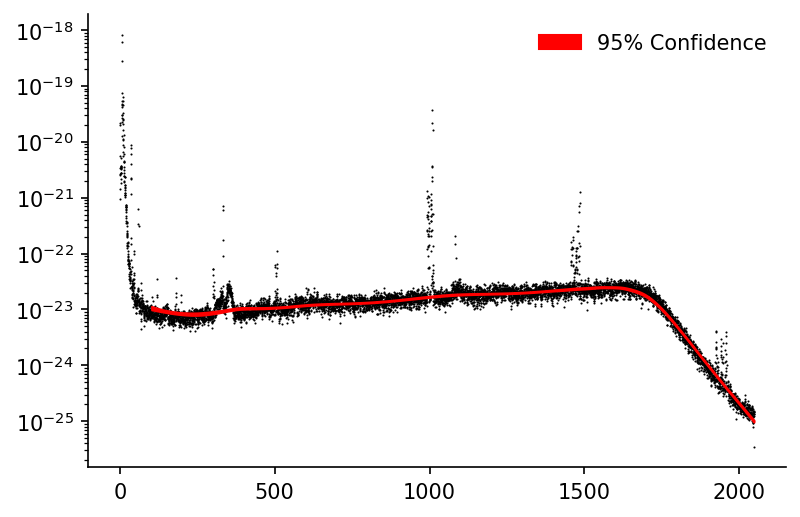

In [59]:
conf_intvl_idxs_to_keep = (s_95pct_conf_intvl<x_max).replace(False, np.nan).dropna().index

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_LIGO['frequency'], df_LIGO['H1'], color='k', linewidth=0, s=1, zorder=1)
ax.fill_between(conf_intvl_idxs_to_keep, np.exp(df_conf_intvl.loc[conf_intvl_idxs_to_keep, 'min']), np.exp(df_conf_intvl.loc[conf_intvl_idxs_to_keep, 'max']), color='r', alpha=1, label='95% Confidence')

ax.set_yscale('log')
ax.legend(frameon=False)
eda.hide_spines(ax)